Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 113s 491ms/step - loss: 0.0066 - mae: 0.0501 - mape: 1341.8542 - val_loss: 0.0023 - val_mae: 0.0382 - val_mape: 13.5003
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 58s 268ms/step - loss: 0.0028 - mae: 0.0367 - mape: 3259.8142 - val_loss: 0.0077 - val_mae: 0.0737 - val_mape: 27.6345
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 63s 294ms/step - loss: 0.0053 - mae: 0.0471 - mape: 1409.6354 - val_loss: 0.0041 - val_mae: 0.0515 - val_mape: 19.9439
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 68s 318ms/step - loss: 0.0046 - mae: 0.0460 - mape: 2388.3672 - val_loss: 0.0021 - val_mae: 0.0358 - val_mape: 13.5314
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 73s 340ms/step - loss: 0.0021 - mae: 0.0303 - mape: 1715.0004 - val_loss: 0.0012 - val_mae: 0.0295 - val_mape: 10.2293
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 75s 349ms/step - loss: 7.6224e-04 - mae: 0.0197 - mape: 74.2996 - val_loss: 9.8048e-04 - val_mae: 0.0280 - val_mape: 9.0675
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 

108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Ratio de Sharpe de la Estrategia: -0.5522549487041626


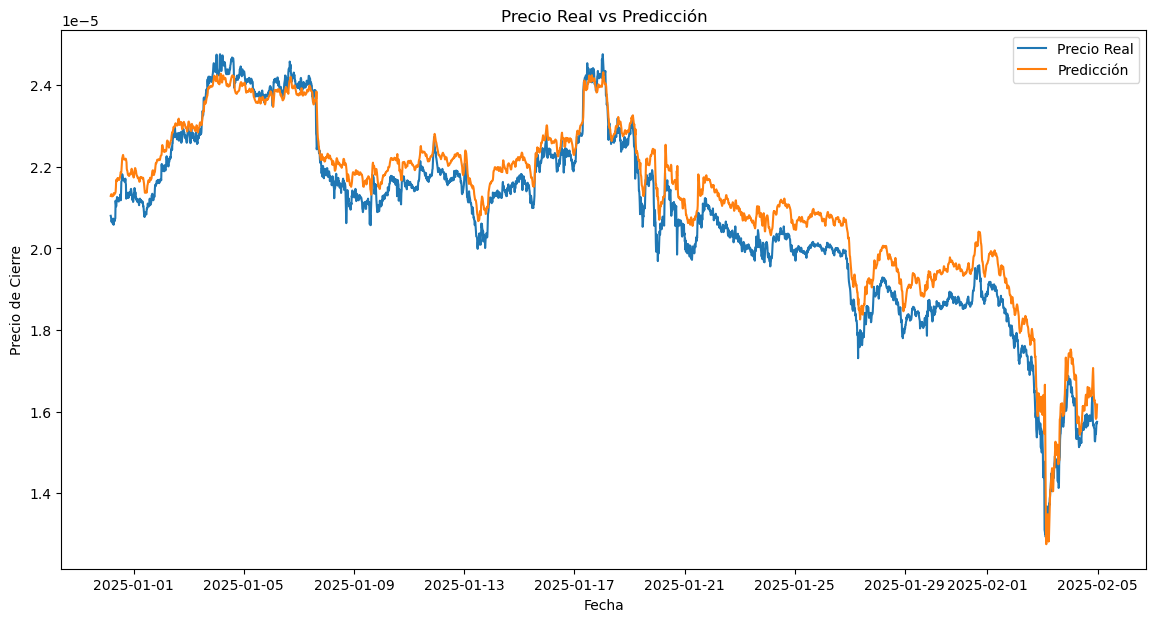

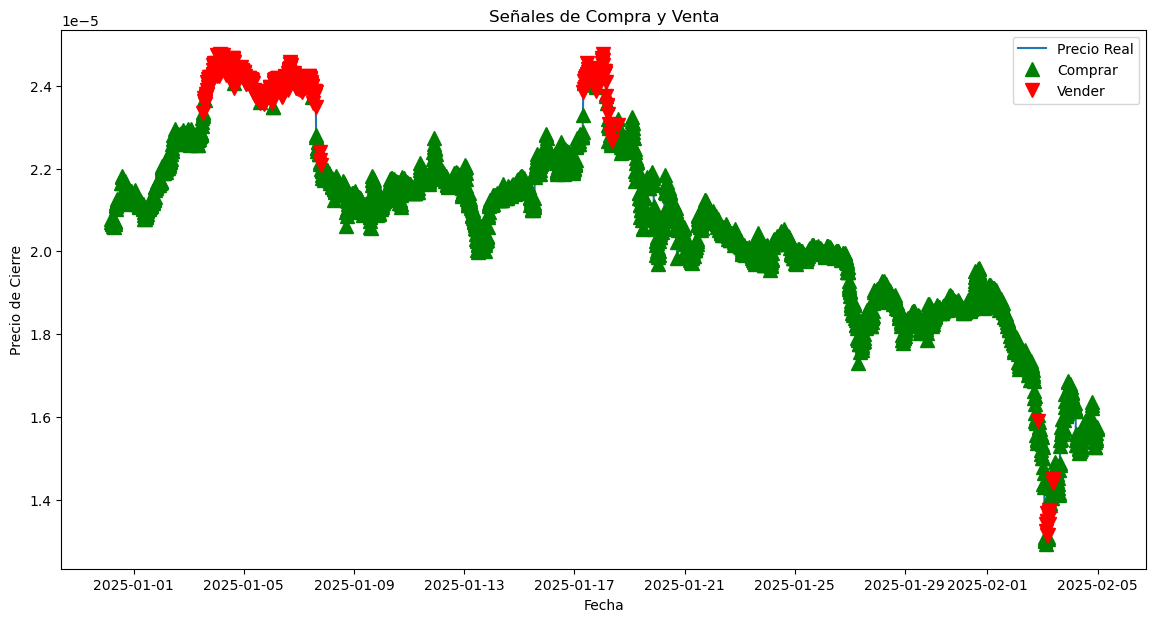

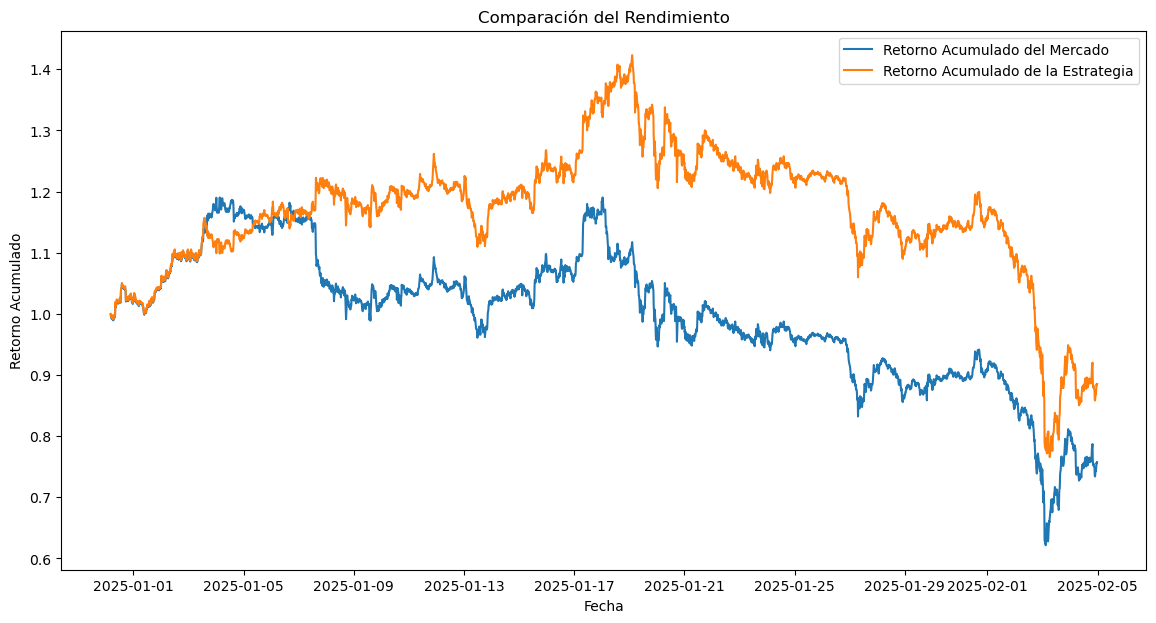

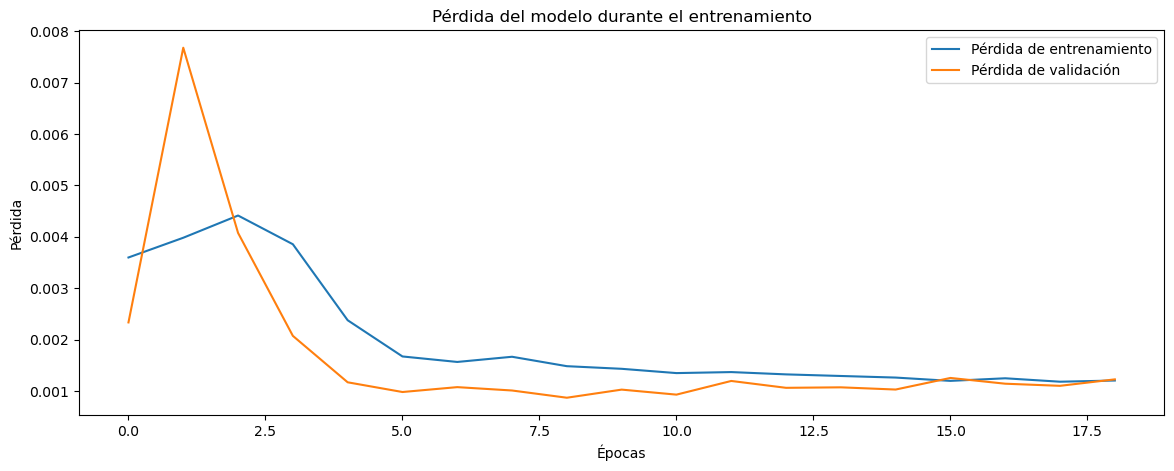

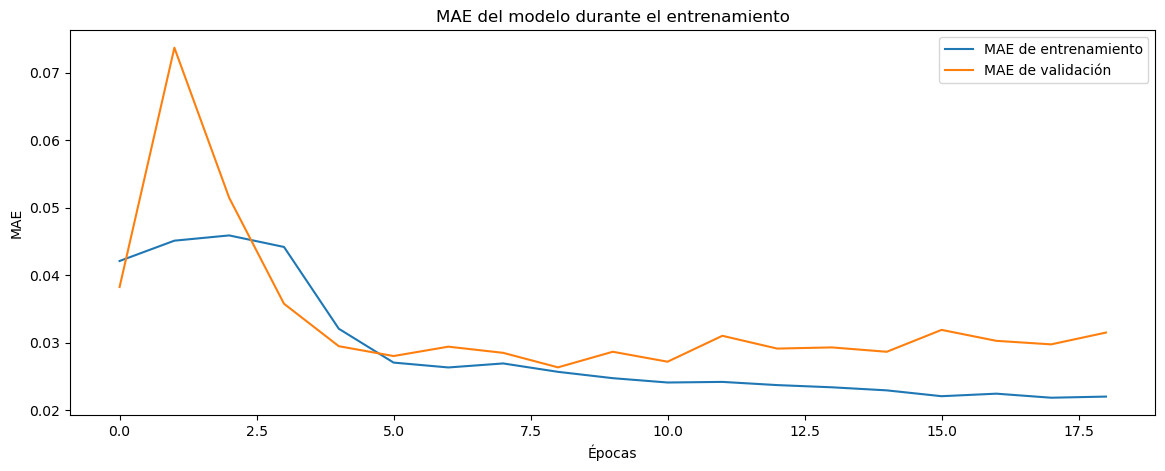

Error Cuadrático Medio (MSE): 3.7216239371798676e-13
Raíz del Error Cuadrático Medio (RMSE): 6.100511402480834e-07
Error Absoluto Medio (MAE): 5.446301130741932e-07
Coeficiente de Determinación (R²): 0.9276792801428589
Reporte de Clasificación:
              precision    recall  f1-score   support

          -1       0.53      0.14      0.22      1854
           0       1.00      1.00      1.00         1
           1       0.46      0.86      0.60      1584

    accuracy                           0.47      3439
   macro avg       0.66      0.67      0.61      3439
weighted avg       0.50      0.47      0.39      3439



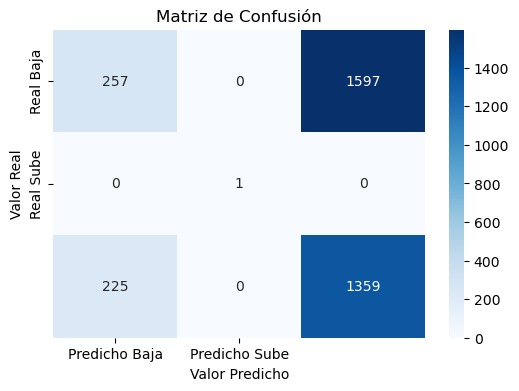

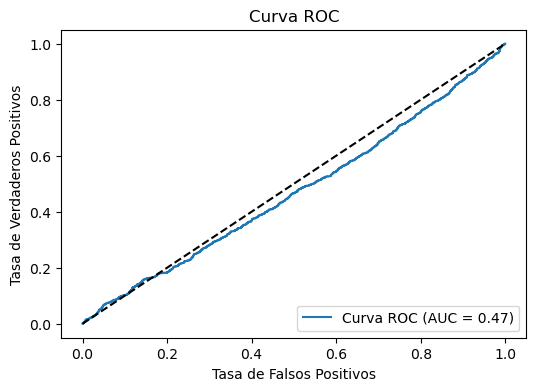

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [3]:
# Importar las clases desde class2.py
from class2 import (
    DataLoader,
    FeatureEngineer,
    LSTMModel,
    TradingStrategy,
    Visualizer,
    FuturePredictor
)

# Importar librerías adicionales para métricas y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# Opcional: Desactivar advertencias
import warnings
warnings.filterwarnings('ignore')

# Paso 1: Cargar los Datos
data_loader = DataLoader(symbol="SHIB/USDT", timeframe='15m', since_days=180)
data = data_loader.fetch_data()
# Opcional: Guardar los datos descargados
data_loader.save_data("shib_15mv2.csv")

# Paso 2: Preparar los Datos
feature_engineer = FeatureEngineer(data)
X_train, X_test, y_train, y_test = feature_engineer.prepare_data(sequence_length=60)
scaler = feature_engineer.scaler
data_columns = feature_engineer.data.columns

# Paso 3: Construir y Entrenar el Modelo
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = LSTMModel(input_shape)
model = lstm_model.build_model()

# Entrenar el modelo
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=50,  # Puedes ajustar el número de epochs según tus necesidades
    batch_size=64  # Puedes ajustar el tamaño de batch según tus recursos
)

# Guardar el modelo y el scaler
lstm_model.save_model('modelo_lstm_shib2.h5')
joblib.dump(scaler, 'scaler.pkl')

# Paso 4: Hacer Predicciones y Generar Señales
trading_strategy = TradingStrategy(scaler, data_columns)
predictions_descaled = trading_strategy.predict(model, X_test)

# Desescalar los valores reales
y_test_full = np.zeros((len(y_test), len(data_columns)))
y_test_full[:, data_columns.get_loc('close')] = y_test
y_test_descaled = scaler.inverse_transform(y_test_full)[:, data_columns.get_loc('close')]

# Crear un DataFrame con los resultados
results = pd.DataFrame({
    'Real': y_test_descaled,
    'Prediccion': predictions_descaled
}, index=feature_engineer.data.index[-len(y_test_descaled):])

# Generar señales
signals = trading_strategy.generate_signals(results['Prediccion'], results['Real'])
results['Señal'] = signals

# Paso 5: Evaluar la Estrategia
# Backtesting
backtest_results = trading_strategy.backtest(results['Real'], results['Señal'])

# Calcular el ratio de Sharpe
sharpe_ratio = trading_strategy.calculate_sharpe_ratio(backtest_results['Estrategia'])
print(f'Ratio de Sharpe de la Estrategia: {sharpe_ratio}')

# Paso 6: Visualizar los Resultados
visualizer = Visualizer()
visualizer.plot_predictions(results['Real'], results['Prediccion'])
visualizer.plot_signals(results['Real'], results['Prediccion'], results['Señal'])
visualizer.plot_backtest(backtest_results)
visualizer.plot_training_history(history)

# Paso 7: Calcular Métricas Adicionales
# Métricas de regresión
mse = mean_squared_error(results['Real'], results['Prediccion'])
mae = mean_absolute_error(results['Real'], results['Prediccion'])
rmse = np.sqrt(mse)
r2 = r2_score(results['Real'], results['Prediccion'])

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse}")
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Coeficiente de Determinación (R²): {r2}")

# Métricas de clasificación
# Crear etiquetas reales basadas en el movimiento real del precio
results['Movimiento Real'] = np.where(results['Real'] > results['Real'].shift(1), 1, -1)
results['Movimiento Real'].iloc[0] = 0  # Manejar el primer valor

# Remover el primer registro que contiene NaN
results = results.dropna()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(results['Movimiento Real'], results['Señal']))

# Matriz de Confusión
cm = confusion_matrix(results['Movimiento Real'], results['Señal'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicho Baja', 'Predicho Sube'],
            yticklabels=['Real Baja', 'Real Sube'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC
# Preparar los datos para la curva ROC
y_true = np.where(results['Movimiento Real'] == 1, 1, 0)
y_scores = results['Prediccion'].diff().fillna(0)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Paso 8: Guardar los Resultados
results.to_csv('resultados_shib.csv')
backtest_results.to_csv('backtest_shib.csv')

# Paso 9: Realizar Predicciones Futuras (Opcional)
# Crear una instancia de FuturePredictor
future_predictor = FuturePredictor(
    scaler=scaler,
    data_columns=data_columns,
    model=model,
    sequence_length=60
)

# Hacer predicciones futuras
results_future, data_with_features = future_predictor.predict_future(
    symbol="SHIB/USDT",
    timeframe='15m',
    limit=200
)

# Obtener los precios reales correspondientes
recent_data_loader = DataLoader(symbol="SHIB/USDT", timeframe='15m', since_days=1)
recent_data = recent_data_loader.fetch_data()
recent_feature_engineer = FeatureEngineer(recent_data)
recent_data = recent_feature_engineer.add_features()
recent_data = recent_data[-len(results_future):]
results_future['Real'] = recent_data['close']



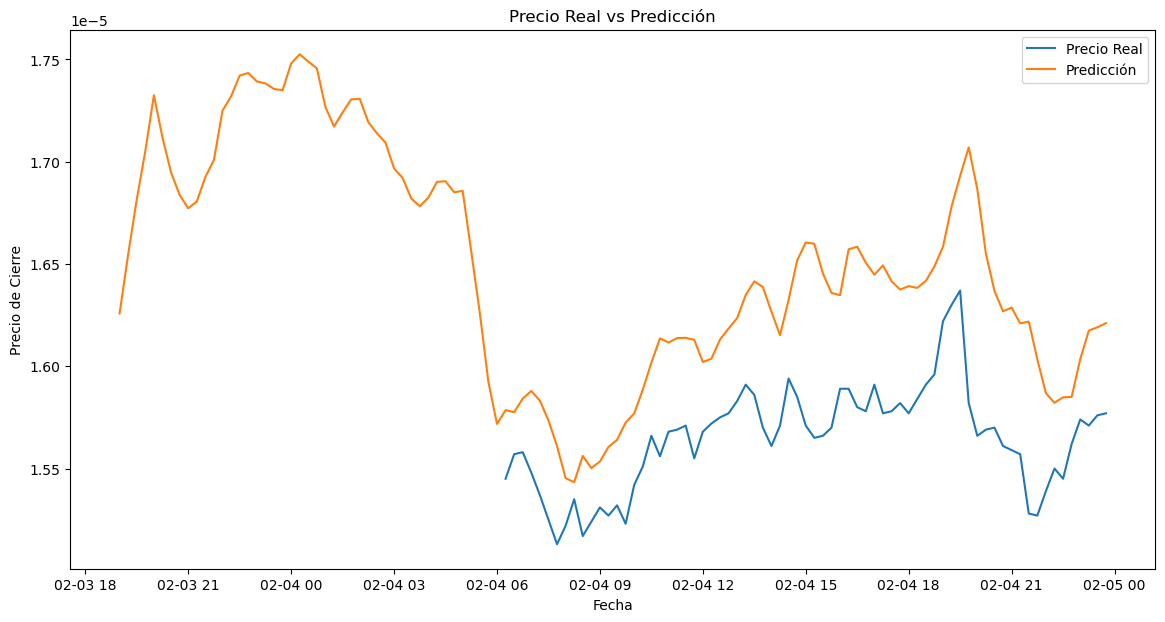

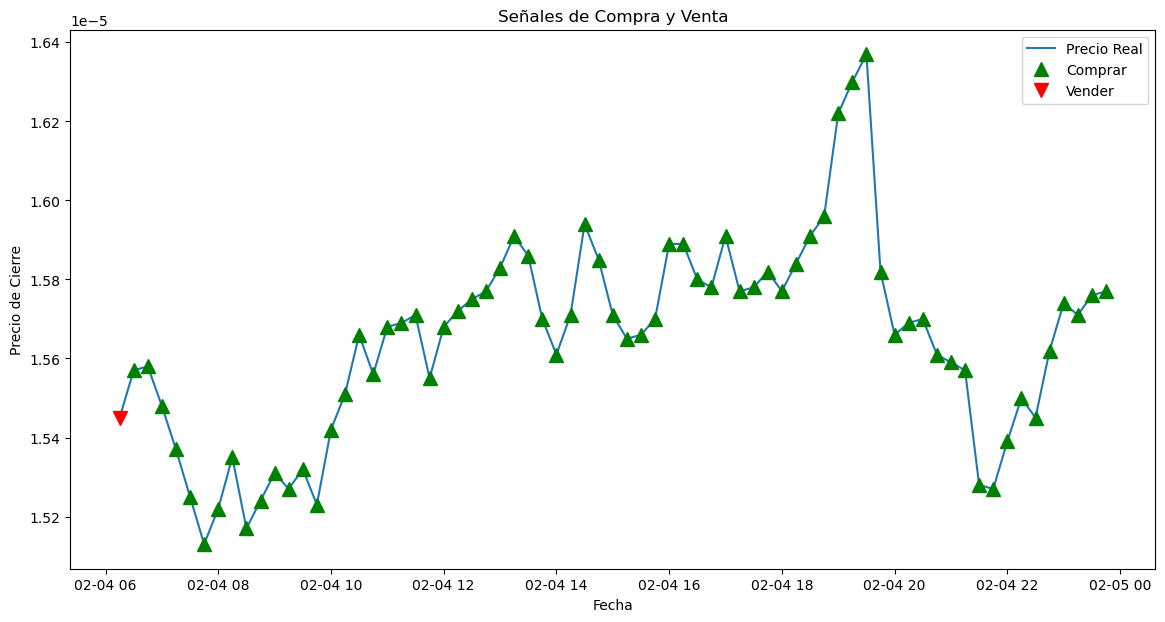

                     Prediccion  Real  Señal
Fecha                                       
2025-02-03 19:00:00    0.000016   NaN      0
2025-02-03 19:15:00    0.000017   NaN     -1
2025-02-03 19:30:00    0.000017   NaN     -1
2025-02-03 19:45:00    0.000017   NaN     -1
2025-02-03 20:00:00    0.000017   NaN     -1


In [4]:
# Generar señales con validación
if 'Real' in results_future.columns and 'Prediccion' in results_future.columns:
    results_future['Señal'] = np.where(
        results_future['Prediccion'] > results_future['Real'].shift(1), 1, -1
    )
    results_future['Señal'].iloc[0] = 0
else:
    print("Error: Las columnas 'Real' y 'Prediccion' no existen en results_future.")

# Visualizar predicciones futuras
visualizer.plot_predictions(results_future['Real'], results_future['Prediccion'])
visualizer.plot_signals(results_future['Real'], results_future['Prediccion'], results_future['Señal'])

# Mostrar primeros registros de los resultados futuros
print(results_future.head())